In [713]:
import fastf1 as ff1
import pandas as pd
from fastf1 import plotting, utils
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from urllib.request import urlopen
import json
import requests
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import GroupShuffleSplit
from sklearn.metrics import mean_squared_error as MSE
import seaborn as sns
from scipy.stats.mstats import winsorize

In [714]:
results = pd.read_parquet('2024_fp3_results.parquet')
results['FP3BestLapTime'] = results['FP3BestLapTime'].dt.total_seconds()
results['FP2BestLapTime'] = results['FP2BestLapTime'].dt.total_seconds()
results['MinQualiTime'] = results['MinQualiTime'].dt.total_seconds()
best_fp3_times = results.groupby(["EventName", "RoundNumber"])[["FP3BestLapTime"]].min().rename(columns={"FP3BestLapTime": "FP3BestOverallLapTime"}).reset_index()
best_fp2_times = results.groupby(["EventName", "RoundNumber"])[["FP2BestLapTime"]].min().rename(columns={"FP2BestLapTime": "FP2BestOverallLapTime"}).reset_index()
best_quali_times = results.groupby(["EventName", "RoundNumber"])[["MinQualiTime"]].min().rename(columns={"MinQualiTime": "MinOverallQualiTime"}).reset_index()
results = pd.merge(results, best_fp3_times, how="left", on=["EventName", "RoundNumber"])
results = pd.merge(results, best_fp2_times, how="left", on=["EventName", "RoundNumber"])
results = pd.merge(results, best_quali_times, how="left", on=["EventName", "RoundNumber"])
results["FP3Delta"] = results["FP3BestLapTime"] - results["FP3BestOverallLapTime"]
results["FP3DeltaFrac"] = results["FP3Delta"] / results["FP3BestLapTime"]
results["FP2Delta"] = results["FP2BestLapTime"] - results["FP2BestOverallLapTime"]
results["FP2DeltaFrac"] = results["FP2Delta"] / results["FP2BestLapTime"]
results["QualiDelta"] = results["MinQualiTime"] - results["MinOverallQualiTime"]
results["QualiDeltaFrac"] = results["QualiDelta"] / results["MinOverallQualiTime"]
print(results.isna().sum())
results = results.dropna(subset=["FP3BestLapTime", "MinQualiTime", "FP3Delta", "QualiDelta", 'FP2BestLapTime', 'FP2Delta'])
results.columns

r2 = results.copy()

DriverNumber               0
BroadcastName              0
Abbreviation               0
DriverId                   0
TeamName                   0
TeamColor                  0
TeamId                     0
FirstName                  0
LastName                   0
FullName                   0
HeadshotUrl                0
CountryCode                0
Position                   0
ClassifiedPosition         0
GridPosition               0
Q1                       462
Q2                       462
Q3                       462
Time                      53
Status                     0
Points                     0
RoundNumber                0
Country                    0
EventName                  0
MinQualiTime               3
FP3BestLapTime             0
FP2BestLapTime             0
FP3BestOverallLapTime      0
FP2BestOverallLapTime      0
MinOverallQualiTime        0
FP3Delta                   0
FP3DeltaFrac               0
FP2Delta                   0
FP2DeltaFrac               0
QualiDelta    

In [715]:
r2.head()

,DriverNumber,BroadcastName,Abbreviation,DriverId,TeamName,TeamColor,TeamId,FirstName,LastName,FullName,...,FP2BestLapTime,FP3BestOverallLapTime,FP2BestOverallLapTime,MinOverallQualiTime,FP3Delta,FP3DeltaFrac,FP2Delta,FP2DeltaFrac,QualiDelta,QualiDeltaFrac
0,1,M VERSTAPPEN,VER,max_verstappen,Red Bull Racing,3671c6,red_bull,Max,Verstappen,Max Verstappen,...,90.851,90.824,90.374,89.165,0.238,0.002614,0.477,0.005250,0.014,0.000157
1,11,S PEREZ,PER,perez,Red Bull Racing,3671c6,red_bull,Sergio,Perez,Sergio Perez,...,91.115,90.824,90.374,89.165,0.424,0.004647,0.741,0.008133,0.372,0.004172
2,55,C SAINZ,SAI,sainz,Ferrari,e8002d,ferrari,Carlos,Sainz,Carlos Sainz,...,90.769,90.824,90.374,89.165,0.000,0.000000,0.395,0.004352,0.342,0.003836
3,16,C LECLERC,LEC,leclerc,Ferrari,e8002d,ferrari,Charles,Leclerc,Charles Leclerc,...,91.113,90.824,90.374,89.165,0.270,0.002964,0.739,0.008111,0.000,0.000000
4,63,G RUSSELL,RUS,russell,Mercedes,27f4d2,mercedes,George,Russell,George Russell,...,90.580,90.824,90.374,89.165,0.366,0.004014,0.206,0.002274,0.320,0.003589


In [716]:
r2 = r2[['DriverNumber', 'RoundNumber', 'QualiDelta', 'FP3Delta']]
r2['RoundNumber'] = r2['RoundNumber'] + 1
r2['Prev5QualiDeltas'] = (
    r2.groupby('DriverNumber')['QualiDelta']
      .transform(lambda x: x.shift().rolling(5, min_periods=1).mean())
)
r2['PrevQualiDelta'] = r2['QualiDelta']
r2['Prev5QualiDeltas'] = r2['Prev5QualiDeltas'].fillna(r2['FP3Delta'])
r2 = r2[['DriverNumber', 'RoundNumber', 'Prev5QualiDeltas', 'PrevQualiDelta']]
results = pd.merge(results, r2, on=['DriverNumber', 'RoundNumber'])


0.5642779328684744
DriverNumber               0
BroadcastName              0
Abbreviation               0
DriverId                   0
TeamName                   0
TeamColor                  0
TeamId                     0
FirstName                  0
LastName                   0
FullName                   0
HeadshotUrl                0
CountryCode                0
Position                   0
ClassifiedPosition         0
GridPosition               0
Q1                       415
Q2                       415
Q3                       415
Time                      48
Status                     0
Points                     0
RoundNumber                0
Country                    0
EventName                  0
MinQualiTime               0
FP3BestLapTime             0
FP2BestLapTime             0
FP3BestOverallLapTime      0
FP2BestOverallLapTime      0
MinOverallQualiTime        0
FP3Delta                   0
FP3DeltaFrac               0
FP2Delta                   0
FP2DeltaFrac           

<Axes: xlabel='PrevQualiDelta', ylabel='QualiDelta'>

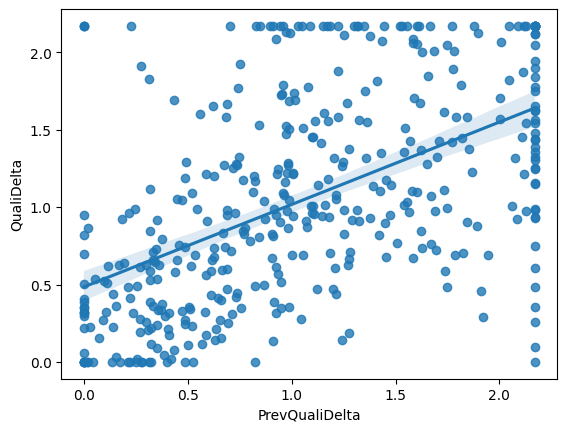

In [717]:
print()
results['FP3Delta'] = winsorize(results['FP3Delta'], limits=(0, 0.1))
results['FP2Delta'] = winsorize(results['FP2Delta'], limits=(0, 0.1))
results['QualiDelta'] = winsorize(results['QualiDelta'], limits=(0, 0.1))
results['Prev5QualiDeltas'] = winsorize(results['Prev5QualiDeltas'], limits=(0, 0.1))
results['PrevQualiDelta'] = winsorize(results['PrevQualiDelta'], limits=(0, 0.1))

corr = results['Prev5QualiDeltas'].corr(results['QualiDelta'])
print(corr)
print(results.isna().sum(axis=0))
sns.regplot(data=results, x='PrevQualiDelta', y ='QualiDelta')

In [718]:
#
key_cols = ["RoundNumber", "DriverNumber"]
x_cols = ['FP3Delta', 'Prev5QualiDeltas', 'FP2Delta', 'PrevQualiDelta']
X = results[key_cols + x_cols].set_index(key_cols)
y = results['QualiDelta']

In [719]:
groups = results['RoundNumber']  # This ensures all rows of the same race stay together

# Define the splitter
gss = GroupShuffleSplit(n_splits=1, test_size=0.2, random_state=2)

# Perform the split
train_idx, test_idx = next(gss.split(X, y, groups=groups))
X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]


In [720]:
X_train

FP3Delta  Prev5QualiDeltas  FP2Delta  PrevQualiDelta
RoundNumber DriverNumber                                                      
3           16               0.000           0.00000     0.000           0.319
            4                0.776           0.44900     0.878           0.660
            81               0.373           0.51800     0.800           0.617
            11               0.300           0.37200     0.813           0.335
            18               0.627           0.80000     0.545           0.778
...                            ...               ...       ...             ...
24          20               0.661           1.11360     0.718           0.867
            30               1.086           1.26975     0.986           1.891
            77               1.046           2.06680     0.713           1.211
            43               1.333           2.06680     1.748           2.074
            11               0.850           2.00100     1.038           0.905

[322 rows x 4 columns]

In [721]:
lr = LinearRegression()
lr.fit(X_train, y_train)
y_pred = lr.predict(X_test)

In [722]:
xx = X_test.copy().drop(columns=x_cols)
xx["prediction"]= y_pred
xx.reset_index()
results

,DriverNumber,BroadcastName,Abbreviation,DriverId,TeamName,TeamColor,TeamId,FirstName,LastName,FullName,...,FP2BestOverallLapTime,MinOverallQualiTime,FP3Delta,FP3DeltaFrac,FP2Delta,FP2DeltaFrac,QualiDelta,QualiDeltaFrac,Prev5QualiDeltas,PrevQualiDelta
0,1,M VERSTAPPEN,VER,max_verstappen,Red Bull Racing,3671c6,red_bull,Max,Verstappen,Max Verstappen,...,88.827,87.472,0.000,0.000000,0.331,0.003713,0.000,0.000000,0.23800,0.014
1,11,S PEREZ,PER,perez,Red Bull Racing,3671c6,red_bull,Sergio,Perez,Sergio Perez,...,88.827,87.472,0.494,0.005556,0.473,0.005297,0.335,0.003830,0.42400,0.372
2,16,C LECLERC,LEC,leclerc,Ferrari,e8002d,ferrari,Charles,Leclerc,Charles Leclerc,...,88.827,87.472,0.196,0.002212,0.353,0.003958,0.319,0.003647,0.27000,0.000
3,81,O PIASTRI,PIA,piastri,McLaren,ff8000,mclaren,Oscar,Piastri,Oscar Piastri,...,88.827,87.472,0.801,0.008979,0.767,0.008561,0.617,0.007054,0.38600,0.518
4,14,F ALONSO,ALO,alonso,Aston Martin,229971,aston_martin,Fernando,Alonso,Fernando Alonso,...,88.827,87.472,0.626,0.007031,0.000,0.000000,0.374,0.004276,0.14100,0.377
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
410,20,K MAGNUSSEN,MAG,kevin_magnussen,Haas F1 Team,B6BABD,haas,Kevin,Magnussen,Kevin Magnussen,...,83.517,82.595,0.661,0.007860,0.718,0.008524,1.037,0.012555,1.11360,0.867
411,30,L LAWSON,LAW,lawson,RB,6692FF,rb,Liam,Lawson,Liam Lawson,...,83.517,82.595,1.086,0.012849,0.986,0.011668,0.877,0.010618,1.26975,1.891
412,77,V BOTTAS,BOT,bottas,Kick Sauber,52e252,sauber,Valtteri,Bottas,Valtteri Bottas,...,83.517,82.595,1.046,0.012382,0.713,0.008465,0.609,0.007373,2.06680,1.211
413,43,F COLAPINTO,COL,colapinto,Williams,64C4FF,williams,Franco,Colapinto,Franco Colapinto,...,83.517,82.595,1.333,0.015726,1.748,0.020501,1.317,0.015945,2.06680,2.074


In [723]:
# create predicted delta column
results = pd.merge(results, xx['prediction'], on=['RoundNumber', 'DriverNumber'])
# create rank of predicted delta
# score actual qualifying position vs predicted qualifying position

In [724]:
results['PredictionRank'] = results.groupby(['RoundNumber'])['prediction'].rank('min')
results.head(10)

,DriverNumber,BroadcastName,Abbreviation,DriverId,TeamName,TeamColor,TeamId,FirstName,LastName,FullName,...,FP3Delta,FP3DeltaFrac,FP2Delta,FP2DeltaFrac,QualiDelta,QualiDeltaFrac,Prev5QualiDeltas,PrevQualiDelta,prediction,PredictionRank
0,1,M VERSTAPPEN,VER,max_verstappen,Red Bull Racing,3671c6,red_bull,Max,Verstappen,Max Verstappen,...,0.000,0.000000,0.331,0.003713,0.000,0.000000,0.238,0.014,0.238755,1.0
1,11,S PEREZ,PER,perez,Red Bull Racing,3671c6,red_bull,Sergio,Perez,Sergio Perez,...,0.494,0.005556,0.473,0.005297,0.335,0.003830,0.424,0.372,0.501624,5.0
2,16,C LECLERC,LEC,leclerc,Ferrari,e8002d,ferrari,Charles,Leclerc,Charles Leclerc,...,0.196,0.002212,0.353,0.003958,0.319,0.003647,0.270,0.000,0.297973,2.0
3,81,O PIASTRI,PIA,piastri,McLaren,ff8000,mclaren,Oscar,Piastri,Oscar Piastri,...,0.801,0.008979,0.767,0.008561,0.617,0.007054,0.386,0.518,0.672306,8.0
4,14,F ALONSO,ALO,alonso,Aston Martin,229971,aston_martin,Fernando,Alonso,Fernando Alonso,...,0.626,0.007031,0.000,0.000000,0.374,0.004276,0.141,0.377,0.323222,3.0
5,63,G RUSSELL,RUS,russell,Mercedes,27f4d2,mercedes,George,Russell,George Russell,...,0.552,0.006205,0.230,0.002583,0.844,0.009649,0.366,0.320,0.422035,4.0
6,4,L NORRIS,NOR,norris,McLaren,ff8000,mclaren,Lando,Norris,Lando Norris,...,0.559,0.006283,0.931,0.010372,0.660,0.007545,0.294,0.449,0.627238,6.0
7,44,L HAMILTON,HAM,hamilton,Mercedes,27f4d2,mercedes,Lewis,Hamilton,Lewis Hamilton,...,0.856,0.009589,0.677,0.007564,0.988,0.011295,0.628,0.545,0.726952,9.0
8,27,N HULKENBERG,HUL,hulkenberg,Haas F1 Team,b6babd,haas,Nico,Hulkenberg,Nico Hulkenberg,...,1.263,0.014084,1.250,0.013877,1.583,0.018097,0.454,0.686,0.965608,11.0
9,23,A ALBON,ALB,albon,Williams,64c4ff,williams,Alexander,Albon,Alexander Albon,...,1.396,0.015544,0.962,0.010714,1.508,0.017240,1.141,1.056,1.151390,14.0


In [725]:
rmse = MSE(results['GridPosition'], results['PredictionRank']) ** 0.5
print(rmse)
pred = results[['GridPosition', 'PredictionRank']]
pred.head(20)



3.5286843020063166


,GridPosition,PredictionRank
0,1.0,1.0
1,3.0,5.0
2,2.0,2.0
3,5.0,8.0
4,4.0,3.0
5,7.0,4.0
6,6.0,6.0
7,8.0,9.0
8,15.0,11.0
9,12.0,14.0


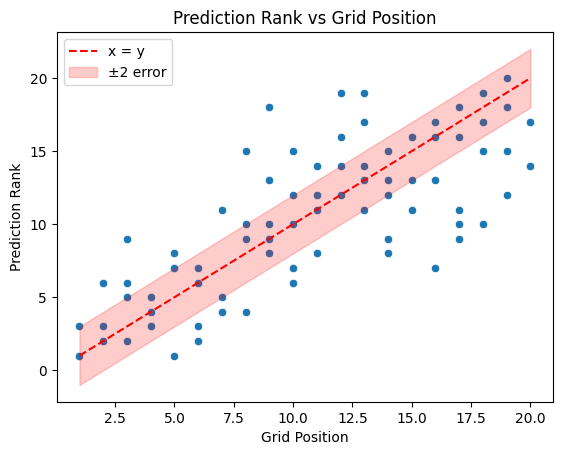

53.76% of predictions are within ±2 of x = y


In [729]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Scatter plot
sns.scatterplot(x=results['GridPosition'], y=results['PredictionRank'])

# Define x values
x_vals = np.linspace(results['GridPosition'].min(), results['GridPosition'].max(), 100)

# Plot y = x line
plt.plot(x_vals, x_vals, color='red', linestyle='--', label='x = y')

# Add ±2 error area
plt.fill_between(x_vals, x_vals - 2, x_vals + 2, color='red', alpha=0.2, label='±2 error')

plt.xlabel('Grid Position')
plt.ylabel('Prediction Rank')
plt.title('Prediction Rank vs Grid Position')
plt.legend()
plt.show()

# Count points inside ±2 of y=x
inside_error = ((results['PredictionRank'] >= results['GridPosition'] - 2) &
                (results['PredictionRank'] <= results['GridPosition'] + 2))

percentage_inside = inside_error.mean() * 100  # mean() gives fraction of True values
print(f"{percentage_inside:.2f}% of predictions are within ±2 of x = y")

